In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [60]:
def extend_vector_with_weekday(hubs,sin,cos,GHI,WS,AT,RA,RD,RI):
    l = []
    for hub in range(len(hubs)):
        h = list(hubs[hub])
        h.extend([sin[hub],cos[hub],GHI[hub],WS[hub],AT[hub],RA[hub],RD[hub],RI[hub]])
        l.append(np.array(h))
    return l

In [61]:
data = pd.read_pickle('DR_Data/pickup_series_6h_weather.pickle')
pickups_out = np.array(data.Hubs)
weekday = True
added_features = 0
if weekday:
    data.Hubs = extend_vector_with_weekday(data.Hubs,data.weekday_sin,data.weekday_cos,data.GHI,data.wind_speed_avg,data.air_temperature, data.rain_accumulation, data.rain_duration, data.rain_intensity)
    added_features = added_features + 8
    
pickups_in = np.array(data.Hubs)

num_zones = pickups_in[0].shape[0] - added_features # -2 from weekdays sin and cos
seq_length = 28
num_intervals = pickups_in.shape[0]-seq_length
num_features = pickups_in[0].shape[0] 

X = np.zeros((num_features, seq_length, num_intervals))
y = np.zeros((num_zones, 1, num_intervals))
for i in range(num_intervals):
    X[:,:,i] = np.array(list(pickups_in[i:i+seq_length])).T
    y[:,:,i] = np.array([pickups_out[i+seq_length]]).T
    
print(X.shape,y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X.transpose(), y.transpose(), test_size=0.2, random_state=1)
#print(X_train.shape, y_train.shape)
#data.head(10)

(108, 28, 1551) (100, 1, 1551)


In [62]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [63]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
use_cuda =False

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [64]:
rnn_seq_length = seq_length
rnn_input_size = num_features
rnn_hidden_size = 16
rnn_direction = 0
rnn_layers = 3

rnn_out_features = rnn_seq_length*rnn_hidden_size*(rnn_direction+1)
features_cat_size = rnn_out_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.drop = Dropout(p=0.9)
        self.bn0 = BatchNorm1d(rnn_seq_length)
        
        self.rnn_1 = nn.LSTM(input_size=rnn_input_size,
                            hidden_size=rnn_hidden_size,
                            num_layers=rnn_layers,
                            bidirectional=(rnn_direction>0),
                            dropout = 0.75)
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=num_zones,
                            bias=True)
        
    def forward(self, x):
        features = []
        out = {}
        
        x = self.bn0(x)
        
        features_rnn = x.view(rnn_seq_length, -1, rnn_input_size)
        features_rnn,_ = self.rnn_1(features_rnn)
        features_rnn = self.drop(features_rnn)
        
        features_rnn = features_rnn.view(-1, rnn_out_features) #self.rnn_1.hidden_size)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        
        #features_final = self.drop(features_final)
        out['out'] = self.l_out(features_final)
        '''
        x, (h,c) = self.rnn_1(x)
        #x = x.view(-1,self.rnn_1.rnn_hidden_size)
        x = self.l_out(x)
        return x
        '''
        return out['out']

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (drop): Dropout(p=0.9, inplace=False)
  (bn0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_1): LSTM(108, 16, num_layers=3, dropout=0.75)
  (l_out): Linear(in_features=448, out_features=100, bias=True)
)


Epoch 0 	 train loss: 2.1469742679 	 valid loss: 2.5528637045 	 valid acc: 0.7230
Epoch 5 	 train loss: 1.7107225733 	 valid loss: 1.4832410295 	 valid acc: 0.5985
Epoch 10 	 train loss: 1.5794681441 	 valid loss: 1.3774726971 	 valid acc: 0.6134
Epoch 15 	 train loss: 1.5570499393 	 valid loss: 1.3091465721 	 valid acc: 0.6397
Epoch 20 	 train loss: 1.4983955145 	 valid loss: 1.2862375583 	 valid acc: 0.6344
Epoch 25 	 train loss: 1.4758935555 	 valid loss: 1.2604268272 	 valid acc: 0.6490
Epoch 30 	 train loss: 1.4583562411 	 valid loss: 1.2591263213 	 valid acc: 0.6620
Epoch 35 	 train loss: 1.4549625872 	 valid loss: 1.2668239866 	 valid acc: 0.6652
Epoch 40 	 train loss: 1.4266295114 	 valid loss: 1.2500979477 	 valid acc: 0.6495
Epoch 45 	 train loss: 1.4228377921 	 valid loss: 1.2570683297 	 valid acc: 0.6725
Epoch 50 	 train loss: 1.4077568318 	 valid loss: 1.2491721417 	 valid acc: 0.6631
Epoch 55 	 train loss: 1.4005789984 	 valid loss: 1.2499408612 	 valid acc: 0.6657
Epoch 

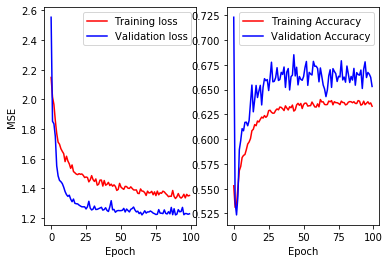

In [65]:
# Hyper-parameters
# setting hyperparameters and gettings epoch sizes
batch_size = 8
num_epochs = 100
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# Define a loss function and optimizer for this problem
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

def accuracy(ys, ts):
    predictions = torch.round(ys)
    correct_prediction = torch.eq(predictions,ts)
    return torch.mean(correct_prediction.float())

# Track loss
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_training_accs = 0
    epoch_training_iter = 0
    epoch_validation_loss = 0
    epoch_validation_accs = 0
    epoch_validation_iter = 0
    
    net.eval()
    for j in range(num_batches_valid):
        inputs = get_variable(torch.Tensor(X_valid[j * batch_size: (j + 1) * batch_size]))
        targets = get_variable(torch.Tensor(np.squeeze(y_valid[j * batch_size: (j + 1) * batch_size])))
        # Forward pass
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Update loss
        epoch_validation_loss += loss.cpu().detach().numpy()
        epoch_validation_accs += accuracy(outputs, targets)
        epoch_validation_iter += 1
    
    net.train()
    for j in range(num_batches_train):
        inputs = get_variable(torch.Tensor(X_train[j * batch_size: (j + 1) * batch_size]))
        targets = get_variable(torch.Tensor(np.squeeze(y_train[j * batch_size: (j + 1) * batch_size])))
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        epoch_training_accs += accuracy(outputs,targets)
        epoch_training_iter += 1
        
    # Save loss for plot
    train_loss.append(epoch_training_loss/epoch_training_iter)
    train_accs.append(epoch_training_accs/epoch_training_iter)
    train_iter.append(i)
    
    valid_loss.append(epoch_validation_loss/epoch_validation_iter)
    valid_accs.append(epoch_validation_accs/epoch_validation_iter)
    valid_iter.append(i)

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i} \t train loss: {train_loss[-1]:.10f} \t valid loss: {valid_loss[-1]:.10f} \t valid acc: {valid_accs[-1]:.4f}')



# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.subplot(1,2,1)
plt.plot(train_iter, train_loss, 'r', label='Training loss',)
plt.plot(valid_iter, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(train_iter, train_accs, 'r', label='Training Accuracy')
plt.plot(valid_iter, valid_accs, 'b', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('')
plt.show()